In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 8: Time series
**Due date: See the [Calendar](https://calendar.google.com/calendar/u/0/embed?src=7a04205ae91b85e82ebc74daddbf2933c6b6723b81abb966f0e69c66a996c43b@group.calendar.google.com&ctz=America/Vancouver&pli=1).**

## Imports

In [1]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

## Submission instructions
<hr>
rubric={points:4}

You will receive marks for correctly submitting this assignment. 

Follow the homework instructions below and at the end of this file. 
There are also detailed [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023s/blob/main/docs/homework_instructions.md) on github.

- **You may work on this assignment in a group (group size <= 4) and submit your assignment as a group.** 
- Below are some instructions on working as a group.  
    - The maximum group size is 4. 
    - You can choose your own group members. 
    - Use group work as an opportunity to collaborate and learn new things from each other. 
    - Be respectful to each other and make sure you understand all the concepts in the assignment well. 
    - It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. [Here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members) are some instructions on adding group members in Gradescope.  
- Upload the .ipynb file to Gradescope.
- **If the .ipynb file is too big or doesn't render on Gradescope for some reason, also upload a pdf or html in addition to the .ipynb.** 
- Make sure that your plots/output are rendered properly in Gradescope.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. We will be forcasting average avocado price for the next week. 

In [2]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
df.shape

(18249, 13)

In [4]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [5]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [6]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [7]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture, we had different measurements for each Location. How about this avocado sales dataset? For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

In [8]:
# BEGIN SOLUTION
df.sort_values(by="Date").head()
# END SOLUTION

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


From the above, we definitely see measurements on the same day at different regions. Let's now group by region.

In [9]:
# BEGIN SOLUTION
df.sort_values(by=["region", "Date"]).head()
# END SOLUTION

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
51,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
50,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
50,2015-01-11,1.77,1182.56,39.00,305.12,0.00,838.44,838.44,0.00,0.0,organic,2015,Albany
49,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany


From the above we see that, even in Albany, we have two measurements on the same date. This seems to be due to the type of avocado.

In [10]:
# BEGIN SOLUTION
df.sort_values(by=["region", "type", "Date"]).head() 
# END SOLUTION

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
50,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
49,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
48,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
47,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany


Great, now we have a sequence of dates with a single row per date. So, the answer is that we have a separate timeseries for each combination of `region` and `type`.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

I think it's not unreasonable to do this on `df` rather than `df_train`, but either way is fine. 

In [11]:
# BEGIN SOLUTION
for name, group in df.groupby(['region', 'type']):
    print("%-40s %s" % (name, group["Date"].sort_values().diff().min()))
# END SOLUTION    

('Albany', 'conventional')               7 days 00:00:00
('Albany', 'organic')                    7 days 00:00:00
('Atlanta', 'conventional')              7 days 00:00:00
('Atlanta', 'organic')                   7 days 00:00:00
('BaltimoreWashington', 'conventional')  7 days 00:00:00
('BaltimoreWashington', 'organic')       7 days 00:00:00
('Boise', 'conventional')                7 days 00:00:00
('Boise', 'organic')                     7 days 00:00:00
('Boston', 'conventional')               7 days 00:00:00
('Boston', 'organic')                    7 days 00:00:00
('BuffaloRochester', 'conventional')     7 days 00:00:00
('BuffaloRochester', 'organic')          7 days 00:00:00
('California', 'conventional')           7 days 00:00:00
('California', 'organic')                7 days 00:00:00
('Charlotte', 'conventional')            7 days 00:00:00
('Charlotte', 'organic')                 7 days 00:00:00
('Chicago', 'conventional')              7 days 00:00:00
('Chicago', 'organic')         

In [12]:
# BEGIN SOLUTION
for name, group in df.groupby(['region', 'type']):
    print("%-40s %s" % (name, group["Date"].sort_values().diff().max()))
# END SOLUTION    

('Albany', 'conventional')               7 days 00:00:00
('Albany', 'organic')                    7 days 00:00:00
('Atlanta', 'conventional')              7 days 00:00:00
('Atlanta', 'organic')                   7 days 00:00:00
('BaltimoreWashington', 'conventional')  7 days 00:00:00
('BaltimoreWashington', 'organic')       7 days 00:00:00
('Boise', 'conventional')                7 days 00:00:00
('Boise', 'organic')                     7 days 00:00:00
('Boston', 'conventional')               7 days 00:00:00
('Boston', 'organic')                    7 days 00:00:00
('BuffaloRochester', 'conventional')     7 days 00:00:00
('BuffaloRochester', 'organic')          7 days 00:00:00
('California', 'conventional')           7 days 00:00:00
('California', 'organic')                7 days 00:00:00
('Charlotte', 'conventional')            7 days 00:00:00
('Charlotte', 'organic')                 7 days 00:00:00
('Chicago', 'conventional')              7 days 00:00:00
('Chicago', 'organic')         

It looks almost perfect - just organic avocados in WestTexNewMexico seems to be missing a couple measurements.

In [13]:
# BEGIN SOLUTION
name
# END SOLUTION

('WestTexNewMexico', 'organic')

In [14]:
# BEGIN SOLUTION
group["Date"].sort_values().diff().value_counts()
# END SOLUTION

7 days     163
14 days      1
21 days      1
Name: Date, dtype: int64

So, in one case there's a 2-week jump, and in one cast there's a 3-week jump.

In [15]:
# BEGIN SOLUTION
group["Date"].sort_values().reset_index(drop=True).diff().sort_values()
# END SOLUTION

1      7 days
106    7 days
107    7 days
108    7 days
109    7 days
        ...  
52     7 days
165    7 days
48    14 days
127   21 days
0         NaT
Name: Date, Length: 166, dtype: timedelta64[ns]

We can see the anomalies occur at index 48 and 127. (Note: I had to `reset_index` because the index was not unique to each row.)

In [16]:
# BEGIN SOLUTION
group["Date"].sort_values().reset_index(drop=True)[45:50]
# END SOLUTION

45   2015-11-15
46   2015-11-22
47   2015-11-29
48   2015-12-13
49   2015-12-20
Name: Date, dtype: datetime64[ns]

We can spot the first anomaly: a 2-week jump from Nov 29, 2015 to Dec 13, 2015.

In [17]:
# BEGIN SOLUTION
group["Date"].sort_values().reset_index(drop=True)[125:130]
# END SOLUTION

125   2017-06-04
126   2017-06-11
127   2017-07-02
128   2017-07-09
129   2017-07-16
Name: Date, dtype: datetime64[ns]

And we can spot the second anomaly: a 3-week jump from June 11, 2017 to July 2, 2017.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

In [18]:
# BEGIN SOLUTION
df["region"].unique()
# END SOLUTION

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

There seems to be a hierarchical structure here: `TotalUS` is split into bigger regions like `West`, `Southeast`, `Northeast`, `Midsouth`; and `California` is split into cities like `Sacramento`, `SanDiego`, `LosAngeles`. It's a bit hard to figure out what's going on.

In [19]:
# BEGIN SOLUTION
df.query("region == 'TotalUS' and type == 'conventional' and Date == '20150104'")["Total Volume"].values[0]
# END SOLUTION

31324277.73

In [20]:
# BEGIN SOLUTION
df.query("region != 'TotalUS' and type == 'conventional' and Date == '20150104'")["Total Volume"].sum()
# END SOLUTION

51730521.73

Since the individual regions sum up to more than the total US, it seems that some of the other regions are double-counted, which is consistent with a hierarchical structure. For example, Los Angeles is probably double counted because it's within `LosAngeles` but also within `California`. What a mess!

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2023s/blob/main/lectures/19_time-series.ipynb), with some improvements.

In [1]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [22]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [23]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [24]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

### 1.4 `AveragePrice` baseline 
rubric={autograde:4}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

In [25]:
train_r2 = None

# BEGIN SOLUTION
train_r2 = r2_score(df_train["AveragePriceNextWeek"], df_train["AveragePrice"])
train_r2
# END SOLUTION

0.8285800937261841

In [26]:
test_r2 = None

# BEGIN SOLUTION
test_r2 = r2_score(df_test["AveragePriceNextWeek"], df_test["AveragePrice"])
test_r2
# END SOLUTION

0.7631780188583048

In [27]:
# BEGIN SOLUTION
df_test["AveragePrice"]
# END SOLUTION

143      1.69
144      1.78
145      1.65
146      1.56
147      1.67
         ... 
18243    1.56
18244    1.57
18245    1.54
18246    1.56
18247    1.56
Name: AveragePrice, Length: 2700, dtype: float64

In [28]:
# BEGIN SOLUTION
df_test["AveragePriceNextWeek"]
# END SOLUTION

143      1.78
144      1.65
145      1.56
146      1.67
147      1.62
         ... 
18243    1.57
18244    1.54
18245    1.56
18246    1.56
18247    1.62
Name: AveragePriceNextWeek, Length: 2700, dtype: float64

Interesting that this is a less effective prediction strategy in the later part of the dataset. I guess that means the price was fluctuating more in late 2017 / early 2018?

In [ ]:
grader.check("q1.4")

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [30]:
# BEGIN SOLUTION
df_train.head()
# END SOLUTION

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99


In [31]:
# BEGIN SOLUTION
(df_train.loc[:, "Small Bags": "XLarge Bags"].sum(axis=1) - df_train["Total Bags"]).abs().max()
# END SOLUTION

1.0

It seems that `Total Bags` is (approximately) the sum of the other 3 bag features, so I will drop `Total Bags`.

In [32]:
# BEGIN SOLUTION
(df_train.loc[:, "4046": "4770"].sum(axis=1) - df_train["Total Volume"]).abs().max()
# END SOLUTION

16298296.29

It seems that `Total Volume` is _not_ the sum of the 3 avocado types, so I will keep all 4 columns.

In [33]:
# BEGIN SOLUTION
df_train.info()
# END SOLUTION

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15441 entries, 0 to 18222
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  15441 non-null  datetime64[ns]
 1   AveragePrice          15441 non-null  float64       
 2   Total Volume          15441 non-null  float64       
 3   4046                  15441 non-null  float64       
 4   4225                  15441 non-null  float64       
 5   4770                  15441 non-null  float64       
 6   Total Bags            15441 non-null  float64       
 7   Small Bags            15441 non-null  float64       
 8   Large Bags            15441 non-null  float64       
 9   XLarge Bags           15441 non-null  float64       
 10  type                  15441 non-null  object        
 11  year                  15441 non-null  int64         
 12  region                15441 non-null  object        
 13  AveragePriceNext

It seems there are no null values, so I will not do any imputation.

Will plot a single time series for exploration purposes:

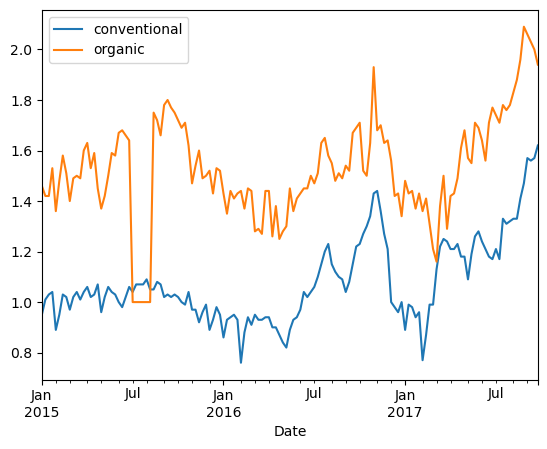

In [34]:
# BEGIN SOLUTION
df_train.query("region == 'TotalUS'").set_index("Date").groupby("type")["AveragePrice"].plot(legend=True);
# END SOLUTION

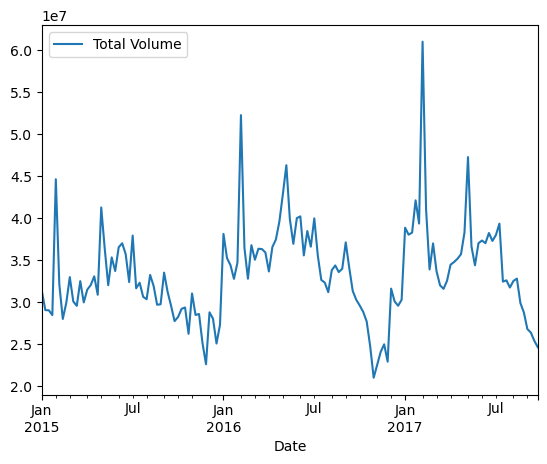

In [35]:
# BEGIN SOLUTION
df_train.query("region == 'TotalUS' and type == 'conventional'").plot(x="Date", y="Total Volume");
# END SOLUTION

We see some seasonality in the total volume, but not much in the average price - interesting.

I will not scale the `AveragePrice` because I am not scaling `AveragePriceNextWeek` either, and it may be helpful to keep them the same. Alternatively, it may have been effective to predict the _change_ in price instead of next's week's price.

In [36]:
# BEGIN SOLUTION
numeric_features     = ["Total Volume", "4046", "4225", "4770", "Small Bags", "Large Bags", "XLarge Bags", "year"]
categorical_features = ["type", "region"]
keep_features        = ["AveragePrice"]
drop_features        = ["Date", "Total Bags"] 
target_feature       = "AveragePriceNextWeek"
# END SOLUTION

Next, I grab the `preprocess_features` function from Lecture 15, with a minor modification to allow un-transformed features via `keep_features`:

In [37]:
# BEGIN SOLUTION
def preprocess_features(df_train, df_test, 
                        numeric_features, 
                        categorical_features, 
                        keep_features, 
                        drop_features, 
                        target_feature):
    
    all_features = numeric_features + categorical_features + keep_features + drop_features + [target_feature]
    if set(df_train.columns) != set(all_features):
        print("Missing columns", set(df_train.columns) - set(all_features))
        print("Extra columns", set(all_features) - set(df_train.columns))
        raise Exception("Columns do not match")
        
    # Put the columns in the order we want
    df_train = df_train[all_features]
    df_test = df_test[all_features]
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first'))
    ])
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features),
        ('passthrough', 'passthrough', keep_features),
        ('drop', 'drop', drop_features + [target_feature])
    ])
    preprocessor.fit(df_train);

    if len(categorical_features) > 0:
        ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
        ohe_feature_names = list(ohe.get_feature_names(categorical_features))
        new_columns = numeric_features + ohe_feature_names + keep_features
    else:
        new_columns = numeric_features + keep_features

    X_train_enc = pd.DataFrame(data=preprocessor.transform(df_train).toarray(), index=df_train.index, columns=new_columns)
    X_test_enc  = pd.DataFrame(data=preprocessor.transform(df_test).toarray(),  index=df_test.index,  columns=new_columns)
    
    y_train = df_train[target_feature]
    y_test  = df_test[ target_feature]
    
    return X_train_enc, y_train, X_test_enc, y_test
# END SOLUTION

This first attempt keeps "year" in as a numeric feature and otherwise drops the date:

In [38]:
# BEGIN SOLUTION
df_train_enc, y_train, df_test_enc, y_test = preprocess_features(df_train, df_test, 
                        numeric_features, 
                        categorical_features, 
                        keep_features, 
                        drop_features, 
                        target_feature)
# END SOLUTION

/Users/lzung/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
# BEGIN SOLUTION
df_train_enc
# END SOLUTION

,Total Volume,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,year,type_organic,region_Atlanta,...,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico,AveragePrice
0,-0.234535,-0.229503,-0.222203,-0.214954,-0.229907,-0.223154,-0.172063,-1.147053,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.22
1,-0.234440,-0.230948,-0.219448,-0.214272,-0.231513,-0.223789,-0.172063,-1.147053,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.24
2,-0.233469,-0.231018,-0.219530,-0.214196,-0.226469,-0.224325,-0.172063,-1.147053,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.17
3,-0.233283,-0.230996,-0.218170,-0.213945,-0.228629,-0.222193,-0.172063,-1.147053,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.06
4,-0.225747,-0.230668,-0.196131,-0.213811,-0.229930,-0.224856,-0.172063,-1.147053,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,-0.241780,-0.229664,-0.242429,-0.215395,-0.229029,-0.225402,-0.172063,1.376692,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.50
18219,-0.244264,-0.231008,-0.242114,-0.215395,-0.239057,-0.225344,-0.172063,1.376692,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.39
18220,-0.243034,-0.230503,-0.241696,-0.215395,-0.234745,-0.225499,-0.172063,1.376692,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.38
18221,-0.243442,-0.230278,-0.243130,-0.215395,-0.234638,-0.225529,-0.172063,1.376692,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.36


In [40]:
# BEGIN SOLUTION
lr = Ridge()
lr.fit(df_train_enc, y_train);
# END SOLUTION

In [41]:
# BEGIN SOLUTION
lr.score(df_train_enc, y_train)
# END SOLUTION

0.8451121096743694

In [42]:
# BEGIN SOLUTION
lr.score(df_test_enc, y_test)
# END SOLUTION

0.7879252704467024

In [43]:
# BEGIN SOLUTION
lr_coef = pd.DataFrame(data=np.squeeze(lr.coef_), index=df_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)
# END SOLUTION

,Coef
AveragePrice,0.802224
type_organic,0.099166
region_SanFrancisco,0.060399
region_HartfordSpringfield,0.057964
region_NewYork,0.040027
...,...
region_CincinnatiDayton,-0.071877
region_Denver,-0.073122
region_SouthCentral,-0.093012
region_DallasFtWorth,-0.093052


In [44]:
# BEGIN SOLUTION
lr_coef.loc["year"]
# END SOLUTION

Coef    0.015609
Name: year, dtype: float64

This is not a very impressive showing. We're doing almost the same as the baseline.

Let's see if encoding the date helps at all. We'll try to OHE the month.

In [45]:
# BEGIN SOLUTION
df_train_month = df_train.assign(Month=df_train["Date"].apply(lambda x: x.month))
df_test_month  = df_test.assign( Month=df_test[ "Date"].apply(lambda x: x.month))
# END SOLUTION

In [46]:
# BEGIN SOLUTION
df_train_month_enc, y_train, df_test_month_enc, y_test = preprocess_features(df_train_month, df_test_month, 
                        numeric_features, 
                        categorical_features + ["Month"], 
                        keep_features, 
                        drop_features, 
                        target_feature)
# END SOLUTION

/Users/lzung/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [47]:
# BEGIN SOLUTION
df_train_month_enc.head()
# END SOLUTION

,Total Volume,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,year,type_organic,region_Atlanta,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,AveragePrice
0,-0.234535,-0.229503,-0.222203,-0.214954,-0.229907,-0.223154,-0.172063,-1.147053,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.22
1,-0.234440,-0.230948,-0.219448,-0.214272,-0.231513,-0.223789,-0.172063,-1.147053,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.24
2,-0.233469,-0.231018,-0.219530,-0.214196,-0.226469,-0.224325,-0.172063,-1.147053,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.17
3,-0.233283,-0.230996,-0.218170,-0.213945,-0.228629,-0.222193,-0.172063,-1.147053,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.06
4,-0.225747,-0.230668,-0.196131,-0.213811,-0.229930,-0.224856,-0.172063,-1.147053,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99


In [48]:
# BEGIN SOLUTION
lr = Ridge()
lr.fit(df_train_month_enc, y_train);
print('Train score: ', lr.score(df_train_month_enc, y_train))
print('Test score: ', lr.score(df_test_month_enc, y_test))
# END SOLUTION

Train score:  0.849364682554632
Test score:  0.8001293268972687


A tiny bit better.

In [49]:
# BEGIN SOLUTION
pd.DataFrame(data=np.squeeze(lr.coef_), index=df_train_month_enc.columns, columns=["Coef"]).sort_values(by="Coef", ascending=False)
# END SOLUTION

,Coef
AveragePrice,0.771853
type_organic,0.114584
Month_9,0.098114
Month_8,0.081332
Month_7,0.069596
...,...
region_CincinnatiDayton,-0.083448
region_Denver,-0.084731
region_SouthCentral,-0.106716
region_DallasFtWorth,-0.107661


Let's add some lag features. I'm arbitrarily deciding on 4 lags for `AveragePrice` (the most important feature).

In [50]:
# BEGIN SOLUTION
def add_lags(df):
    df = create_lag_feature(df, "AveragePrice", -1, ["region", "type"])
    df = create_lag_feature(df, "AveragePrice", -2, ["region", "type"])
    df = create_lag_feature(df, "AveragePrice", -3, ["region", "type"])
    df = create_lag_feature(df, "AveragePrice", -4, ["region", "type"])
    return df

df_train_month_lag = add_lags(df_train_month)
df_test_month_lag  = add_lags(df_test_month)
df_train_month_lag
# END SOLUTION

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek,Month,AveragePrice_lag1,AveragePrice_lag2,AveragePrice_lag3,AveragePrice_lag4
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24,1,NaN,NaN,NaN,NaN
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17,1,1.22,NaN,NaN,NaN
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06,1,1.24,1.22,NaN,NaN
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99,1,1.17,1.24,1.22,NaN
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99,2,1.06,1.17,1.24,1.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,2017-08-27,2.50,16137.93,2616.96,3672.96,0.00,9848.01,9816.58,31.43,0.0,organic,2017,WestTexNewMexico,2.39,8,2.43,2.01,1.78,1.67
18219,2017-09-03,2.39,7657.47,927.27,4056.73,0.00,2673.47,2629.18,44.29,0.0,organic,2017,WestTexNewMexico,2.38,9,2.50,2.43,2.01,1.78
18220,2017-09-10,2.38,11857.31,1562.10,4565.41,0.00,5729.80,5719.96,9.84,0.0,organic,2017,WestTexNewMexico,2.36,9,2.39,2.50,2.43,2.01
18221,2017-09-17,2.36,10464.29,1845.14,2819.17,0.00,5799.98,5796.65,3.33,0.0,organic,2017,WestTexNewMexico,2.26,9,2.38,2.39,2.50,2.43


In [51]:
# BEGIN SOLUTION
df_train_month_lag_enc, y_train, df_test_month_lag_enc, y_test = preprocess_features(df_train_month_lag, df_test_month_lag, 
                        numeric_features + ["AveragePrice_lag1", "AveragePrice_lag2", "AveragePrice_lag3", "AveragePrice_lag4"], 
                        categorical_features + ["Month"], 
                        keep_features, 
                        drop_features, 
                        target_feature)
# END SOLUTION

/Users/lzung/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [52]:
# BEGIN SOLUTION
lr = Ridge()
lr.fit(df_train_month_lag_enc, y_train);
print("Train scores: ", lr.score(df_train_month_lag_enc, y_train))
print("Test scores: ", lr.score(df_test_month_lag_enc, y_test))
# END SOLUTION

Train scores:  0.8595737220705675
Test scores:  0.799928400814505


This did not seem to help.

In [53]:
# BEGIN SOLUTION
pd.DataFrame(data=np.squeeze(lr.coef_), index=df_train_month_lag_enc.columns, columns=["Coef"]).sort_values(by="Coef", ascending=False)
# END SOLUTION

,Coef
AveragePrice,0.578971
Month_9,0.080655
type_organic,0.068920
Month_8,0.068412
Month_7,0.062242
...,...
region_CincinnatiDayton,-0.046909
region_Denver,-0.049935
region_SouthCentral,-0.061838
region_DallasFtWorth,-0.063216


<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: very short answer questions

Each question is worth 2 points.

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:4}

The following questions pertain to Lecture 19 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

1. Many many examples: credit card transactions, log files, basically any situation where the frequency of the measurements could not be chosen by the person taking the measurements. 
2. Encoding the date as, e.g. OHE month works just fine with unequally spaced points. However, the lag features are more problematic, because the "previous" measurement will be a different length of time away in each case. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Survival analysis
rubric={points:6}

The following questions pertain to [Lecture 20](https://github.com/UBC-CS/cpsc330-2023s/blob/main/lectures/20_survival-analysis.ipynb) on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer?
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

_Type your answer here, replacing this text._

1. The "not churned" are censored - we don't know if they will churn shortly or in a long time. These people have the same label and our model will be impacted negatively.
2. Not enough information - it depends! Imagine a subscription service where you have to pay a starter fee after a month and then pay a huge fee after a year. Well, customer B just paid that huge fee and will probably stay a while, whereas customer A may leave before paying the huge fee, so customer A will probably leave first. But imagine a service where people are more and more likely to leave every day, e.g. a movie service with only 100 movies, so you can run out easily. In that case customer B will probably leave first.
3. The customer is very unlikely to leave during that period.

<!-- END QUESTION -->

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
4. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

![](img/eva-well-done.png)